# Pre-analysis of data
Here we join the files to be used in the analysis phase. We experiment with the parameters of the classifiers. We use those to classify galaxies in another notebook.
First, we import all the packages

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import xgboost as xgb
from astropy.table import Table, join

from sklearn import preprocessing
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

Additionally, we include some shortcuts to simplify some code

In [3]:
def selt1_or_selt2(tab_phot):
    """Select Seyferts 1 and 2 in both VCV and CDS"""
    selec1 = np.logical_and(tab_phot['otype_txt'] == 'Sy1', tab_phot['Sp'] == 'S1')
    selec2 = np.logical_and(tab_phot['otype_txt'] == 'Sy2', tab_phot['Sp'] == 'S2')
    select_sey = np.logical_or(selec1, selec2)
    return tab_phot[select_sey]

## Join all clean results

We read the results from the models we are going to use

In [4]:
ModelS = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK.fits', format='fits')
ModelF = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr.fits', format='fits')

ModelS37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK37.fits', format='fits')
ModelF37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr37.fits', format='fits')

We also read the original database of galaxies, where we take the information for the classification

In [5]:
Sample = Table.read('../Data/Final/VCV_SMB_otype.txt', format='ascii')
Sample.rename_column('main_id', 'id')  # Renamed to use the join with the same id

We join these clean tables with the catalog. We send all the tables to pandas format. Then, we concatenate the tables to have an unique table.

In [6]:
SPandas = join(Sample, ModelS, keys='id').to_pandas()
FPandas = join(Sample, ModelF, keys='id').to_pandas()
SPandas37 = join(Sample, ModelS37, keys='id').to_pandas()
FPandas37 = join(Sample, ModelF37, keys='id').to_pandas()
SFPandas = pd.concat([SPandas, FPandas, SPandas37, FPandas37],
                     keys=['SKIRTOR', 'Fritz', 'S37', 'F37'],
                     names=['Model', 'idCIG'])

## Experiments with the parameters of the classifiers
We select the physical parameters in all the models and remove the ones that are not useful for our propose (e.g. constant values, young and old contributions).

In [7]:
GoodColumns = [col for col in selt1_or_selt2(SFPandas).loc['SKIRTOR'].columns if 'bayes' in col]
newdf = selt1_or_selt2(SFPandas).loc['SKIRTOR'][GoodColumns]
Descr = newdf.describe()
BadCol = [cl for cl in newdf.columns if Descr[cl]['std'] < 1e-2]  # Removing constant columns
newdf = newdf.drop(BadCol, axis=1)
# Removing calculated errors
BadCol2 = [cl for cl in newdf.columns if '_err' in cl]
newdf = newdf.drop(BadCol2, axis=1)
# Removing young estimations
BadCol3 = [cl for cl in newdf.columns if '_young' in cl]
# Removing old estimations
BadCol4 = [cl for cl in newdf.columns if '_old' in cl]
# Removing estimations with lines
BadCol5 = [cl for cl in newdf.columns if '_lines' in cl]
# Removing universe values, these are dependent of redshift
BadCol6 = [cl for cl in newdf.columns if 'universe' in cl]
# Removing filter in the attenuation module
BadCol7 = [cl for cl in newdf.columns if 'FUV' in cl]
BadCols = np.concatenate([BadCol3, BadCol4, BadCol5, BadCol6, BadCol7])
newdf = newdf.drop(BadCols, axis=1)
newdf = newdf.dropna(axis='columns')
newdf = newdf[newdf.columns[:-31]]  # Remove the mock photometry

We split the sample of galaxies into train and test sets. Then, we encode and scale the physical parameters.

In [8]:
X = newdf
y = selt1_or_selt2(SFPandas).loc['SKIRTOR']['otype_txt']
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42)
le = preprocessing.LabelEncoder()
le.fit(y)
x_train_encode = preprocessing.robust_scale(x_train)
x_test_encode = preprocessing.robust_scale(x_test)
y_train_encode = le.transform(y_train).reshape(-1, 1).ravel()
y_test_encode = le.transform(y_test).reshape(-1, 1).ravel()

## Using GridSearchCV to find the best parameters for the classifiers

We selected two different classifiers ([Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)). We will experiment with Grid Search. We test a model with default values and we compare with the [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) accuracy scoring (`GridSearchCV`).

In [9]:
clf_rf = RandomForestClassifier(random_state=42)
clf_xg = xgb.XGBClassifier(random_state=42, use_label_encoder=False,
                           eval_metric='logloss')
param_grid = {"max_depth": [10, 15, 20, 25, 30, 35, 40],
              "n_estimators": [200, 400, 600, 800, 1000]}

**IMPORTANT COMMENT:**  If you want to see the all the details of the runs (verbose) do not set the n_jobs parameter. The evaluation on the points are shown in the terminal when the cell finish running. Do not set any n_jobs for the XGBoost classifier! It will take a longer time.

In [10]:
search = GridSearchCV(clf_xg, param_grid, scoring='accuracy',
                      verbose=4).fit(x_train_encode, y_train_encode)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... max_depth=10, n_estimators=200, score=0.914, total=   0.8s
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ...... max_depth=10, n_estimators=200, score=0.902, total=   0.8s
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] ...... max_depth=10, n_estimators=200, score=0.915, total=   0.8s
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV] ...... max_depth=10, n_estimators=200, score=0.892, total=   0.7s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.914, total=   0.8s
[CV] max_depth=10, n_estimators=400 ..................................
[CV] ...... max_depth=10, n_estimators=400, score=0.916, total=   1.2s
[CV] max_depth=10, n_estimators=400 ..................................
[CV] ...... max_depth=10, n_estimators=400, score=0.902, total=   1.2s
[CV] max_depth=10, n_estimators=400 ..................................
[CV] ...... max_depth=10, n_estimators=400, score=0.916, total=   1.2s
[CV] max_depth=10, n_estimators=400 ..................................
[CV] ...... max_depth=10, n_estimators=400, score=0.893, total=   1.2s
[CV] max_depth=10, n_estimators=400 ..................................
[CV] ...... max_depth=10, n_estimators=400, score=0.915, total=   1.2s
[CV] max_depth=10, n_estimators=600 ..................................
[CV] .

[CV] ...... max_depth=20, n_estimators=600, score=0.901, total=   1.5s
[CV] max_depth=20, n_estimators=600 ..................................
[CV] ...... max_depth=20, n_estimators=600, score=0.910, total=   1.5s
[CV] max_depth=20, n_estimators=600 ..................................
[CV] ...... max_depth=20, n_estimators=600, score=0.895, total=   1.5s
[CV] max_depth=20, n_estimators=600 ..................................
[CV] ...... max_depth=20, n_estimators=600, score=0.919, total=   1.8s
[CV] max_depth=20, n_estimators=800 ..................................
[CV] ...... max_depth=20, n_estimators=800, score=0.911, total=   1.8s
[CV] max_depth=20, n_estimators=800 ..................................
[CV] ...... max_depth=20, n_estimators=800, score=0.901, total=   2.0s
[CV] max_depth=20, n_estimators=800 ..................................
[CV] ...... max_depth=20, n_estimators=800, score=0.912, total=   2.0s
[CV] max_depth=20, n_estimators=800 ..................................
[CV] .

[CV] ...... max_depth=30, n_estimators=800, score=0.917, total=   1.8s
[CV] max_depth=30, n_estimators=1000 .................................
[CV] ..... max_depth=30, n_estimators=1000, score=0.909, total=   2.0s
[CV] max_depth=30, n_estimators=1000 .................................
[CV] ..... max_depth=30, n_estimators=1000, score=0.900, total=   2.0s
[CV] max_depth=30, n_estimators=1000 .................................
[CV] ..... max_depth=30, n_estimators=1000, score=0.912, total=   2.0s
[CV] max_depth=30, n_estimators=1000 .................................
[CV] ..... max_depth=30, n_estimators=1000, score=0.895, total=   2.0s
[CV] max_depth=30, n_estimators=1000 .................................
[CV] ..... max_depth=30, n_estimators=1000, score=0.917, total=   2.0s
[CV] max_depth=35, n_estimators=200 ..................................
[CV] ...... max_depth=35, n_estimators=200, score=0.912, total=   0.8s
[CV] max_depth=35, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  4.4min finished


The results from the `GridSearchCV` gives us the best parameters for the classifiers.

In [11]:
search.best_params_ ## For the XGB classifier

{'max_depth': 15, 'n_estimators': 600}

In [12]:
search2 = GridSearchCV(clf_rf, param_grid, scoring='accuracy', n_jobs=6,
                       verbose=4).fit(x_train_encode, y_train_encode)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   11.9s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 175 out of 175 | elapsed:  3.4min finished


In [13]:
search2.best_params_ ## For the RF classifier

{'max_depth': 10, 'n_estimators': 1000}

Then, we use those values for the n_estimator and max_depth in these two classifiers.

In [14]:
clf_xg2 = xgb.XGBClassifier(n_estimators=search.best_params_['n_estimators'],
                            max_depth=search.best_params_['max_depth'],
                            random_state=42, use_label_encoder=False, eval_metric='logloss')
clf_rf2 = RandomForestClassifier(n_estimators=search2.best_params_['n_estimators'],
                                 max_depth=search2.best_params_['max_depth'], random_state=42)

##### Minor check on the calibration curve

We add a simple calibration plot to see if the probabilistic predictions of the classifiers are calibrated.

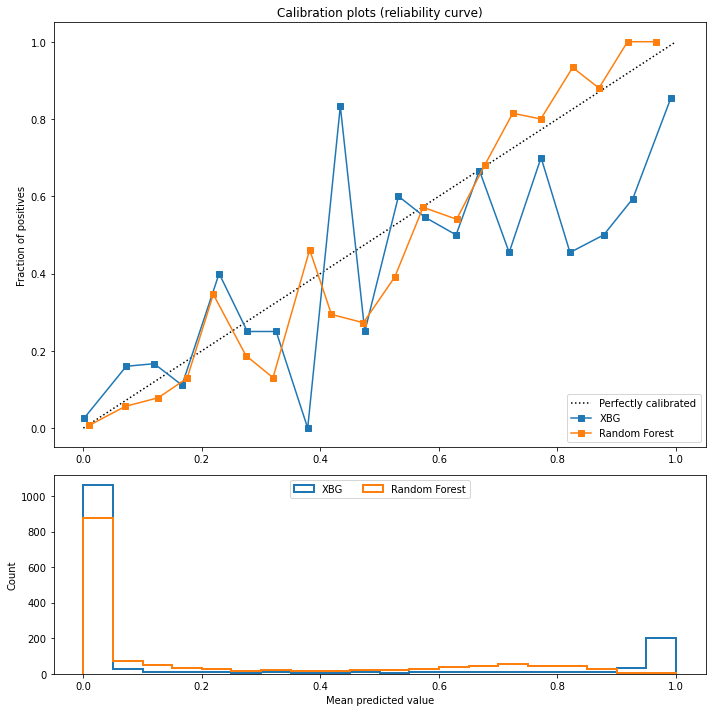

In [15]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(clf_xg2, 'XBG'),
                  (clf_rf2, 'Random Forest')]:
    clf.fit(x_train_encode, y_train_encode)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(x_test_encode)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(x_test_encode)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_encode,
                                                                    prob_pos, n_bins=20)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

##### Notebook info

In [16]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w 

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.25.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
sklearn   : 0.23.1
pandas    : 1.2.0
autopep8  : 1.5.7
xgboost   : 1.3.3
matplotlib: 3.2.2
logging   : 0.5.1.2
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
numpy     : 1.19.5
json      : 2.0.9
re        : 2.2.1

Watermark: 2.1.0

